Привет! Это мое решение всем известного титаника с кегла ! Надеюсь ,  что оно вам понравится !

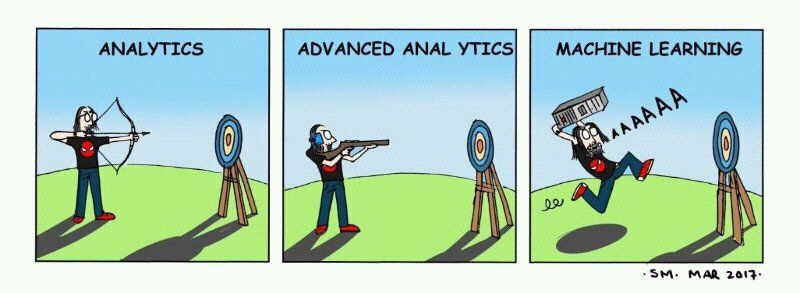

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import randint
import shap

random.seed(42)
np.random.seed(42)

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


1. Анализ и предобработка данных

In [240]:
train_df = pd.read_csv("/content/drive/MyDrive/titanic/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/titanic/test.csv")
submission = pd.read_csv('/content/drive/MyDrive/titanic/gender_submission.csv')
train_df.drop('PassengerId',axis=1,inplace=True)
test_df.drop('PassengerId',axis=1,inplace=True)
train_df.drop('Name',axis=1,inplace=True)
test_df.drop('Name',axis=1,inplace=True)
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,male,54.0,0,0,17463,51.8625,E46,S
7,0,3,male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,female,14.0,1,0,237736,30.0708,NaN,C


Посмотрим описательную статистику для каждой фичи.С первого взгялда нельзя сказать есть ли какие-то явные выбросы в данных или нет , посмотрим их распределение далее

In [241]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


В возрасте пропущенные значения заполним медианами , кабинки рассмотрю подробнее возможно у самого низкого класса комфорта просто их не было

In [242]:
train_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687
Embarked,2


In [243]:
test_df.isna().sum()

,0
Pclass,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327
Embarked,0


Вообщем-то как и ожидалось у пассажиров с 3 классом комфорта просто не было фиксированного места поэтому у них пропуски в колонке кабинка

In [244]:
train_df[train_df['Cabin'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
7,0,3,male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...
884,0,3,male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,0,3,female,39.0,0,5,382652,29.1250,NaN,Q
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Для пассажиров 3 класс заполним пропуски категорией "No_cabin"

In [245]:
train_df.loc[(train_df['Pclass'] == 3) & (train_df['Cabin'].isna()), 'Cabin'] = "No_cabin"
test_df.loc[(test_df['Pclass'] == 3) & (test_df['Cabin'].isna()), 'Cabin'] = "No_cabin"

In [246]:
train_df['Cabin'].isna().sum()

np.int64(208)

In [247]:
test_df['Cabin'].isna().sum()

np.int64(113)

Осталось 208 пропусков , рассмотрим их  подробнее немного позже

Пассажиры у которых Emarked отсутствует очевидно просто не сели на круиз и поэтому выжили

In [248]:
train_df[train_df['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,female,62.0,0,0,113572,80.0,B28,NaN


Заполню такие пропуски катигорией 'No_board'

In [249]:
train_df['Embarked'].fillna('No_board',inplace=True)
test_df['Embarked'].fillna('No_board',inplace=True)

<ipython-input-249-5d1738e41559>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna('No_board',inplace=True)
<ipython-input-249-5d1738e41559>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [250]:
train_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,208
Embarked,0


Необходимо выяснить причину того , что у пассажиров более высокого класса не было кабинок.Думаю , что у пассажиров среднего и высокого класса были фиксированные кабинки , пропуски в этих значениях можно считать ошибкой и не более ,заполню пропуски модой

In [251]:
train_df[(train_df['Cabin'].isna()) & (train_df['Pclass']!= 3)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
9,1,2,female,14.0,1,0,237736,30.0708,NaN,C
15,1,2,female,55.0,0,0,248706,16.0000,NaN,S
17,1,2,male,NaN,0,0,244373,13.0000,NaN,S
20,0,2,male,35.0,0,0,239865,26.0000,NaN,S
30,0,1,male,40.0,0,0,PC 17601,27.7208,NaN,C
...,...,...,...,...,...,...,...,...,...,...
866,1,2,female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C
874,1,2,female,28.0,1,0,P/PP 3381,24.0000,NaN,C
880,1,2,female,25.0,0,1,230433,26.0000,NaN,S
883,0,2,male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S


In [252]:
mode_class1 = train_df[train_df['Pclass'] == 1]['Cabin'].mode()[0]

mode_class2 = train_df[train_df['Pclass'] == 2]['Cabin'].mode()[0]

In [253]:
train_df.loc[(train_df['Pclass'] == 1) & (train_df['Cabin'].isna()), 'Cabin'] = mode_class1
train_df.loc[(train_df['Pclass'] == 2) & (train_df['Cabin'].isna()), 'Cabin'] = mode_class2
test_df.loc[(test_df['Pclass'] == 1) & (test_df['Cabin'].isna()), 'Cabin'] = mode_class1
test_df.loc[(test_df['Pclass'] == 2) & (test_df['Cabin'].isna()), 'Cabin'] = mode_class2

In [254]:
imp_median = SimpleImputer( strategy='median')
s = imp_median.fit(train_df[['Age']])
train_df['Age'] = s.transform(train_df[['Age']])
test_df['Age'] = s.transform(test_df[['Age']])
s = imp_median.fit(train_df[['Fare']])
test_df['Fare'] = s.transform(test_df[['Fare']])

С пропусками в данных разобрался , вообще можно было бы столбец с кабинкой просто выкинуть , сказав , что он очень разреженный , но я решил попробовать в предобработку

In [255]:
train_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,0
Embarked,0


Преобразую тип данных 'object' в 'category'

In [256]:
train_df.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object
Embarked,object


In [257]:
category_columns = train_df.select_dtypes(include=['object']).columns.tolist()
train_df[category_columns] = train_df[category_columns].astype('category')
test_df[category_columns] = test_df[category_columns].astype('category')

In [258]:
train_df.dtypes

,0
Survived,int64
Pclass,int64
Sex,category
Age,float64
SibSp,int64
Parch,int64
Ticket,category
Fare,float64
Cabin,category
Embarked,category


Преобразовал objects в категорию, теперь посмотрю есть ли дубликаты

In [259]:
train_df.duplicated().sum()

np.int64(16)

Гляну на распределение основынх фичей. Думаю , что наиболее важными окажутся :

1.   Возраст - у младенцев и пожилых людей шансы на выживание явно ниже чем у людей среднего возраста
2.   Пол - поскольку первыми спасают женщин и детей ,думаю , что женщины буду выживать чаще
3.   Класс билета - мне кажется , что пассажирам с более высоким классом билета оказывали большую помощь





Средний возраст в районе 30 лет - распределение данных логично

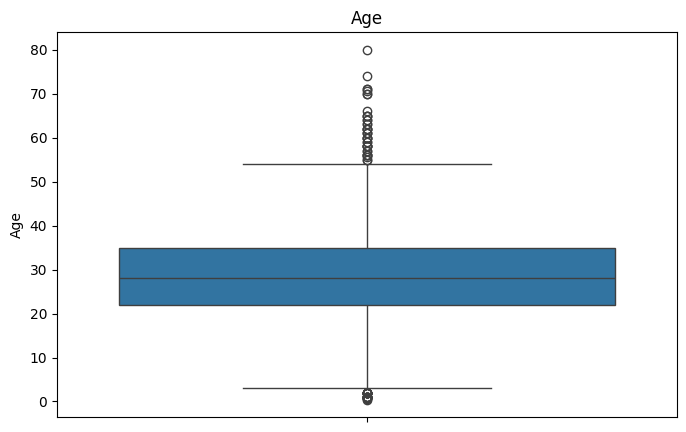

In [260]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['Age'])

plt.title('Age')

plt.show()

Мужчин значительно больше

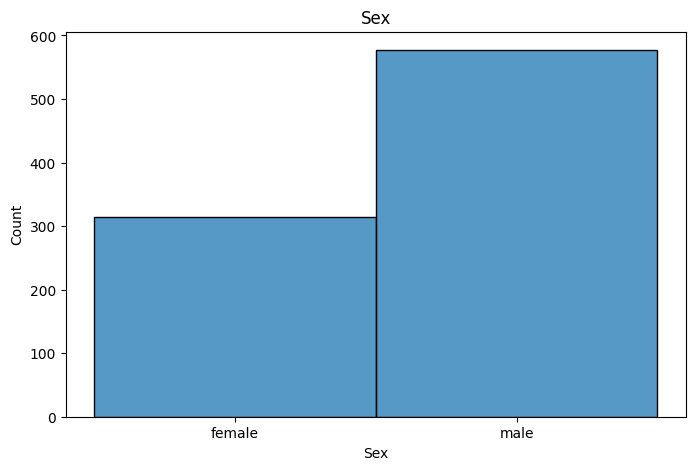

In [261]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['Sex'])

plt.title('Sex')

plt.show()

Больше всего пассажиров 3 класса

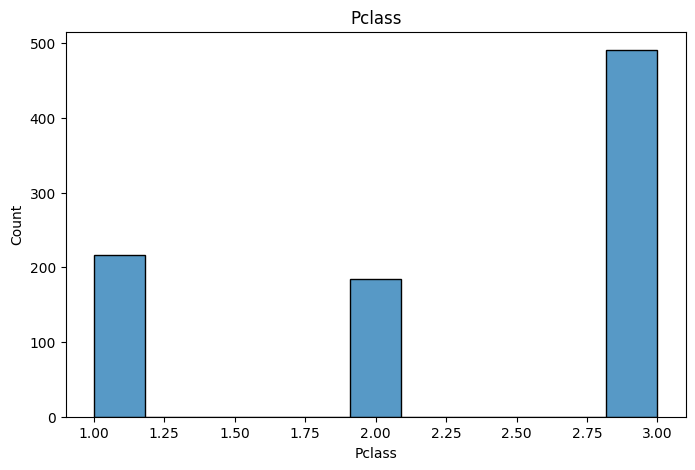

In [262]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['Pclass'])

plt.title('Pclass')

plt.show()

По рассмотренным фичам можно сделать следующие предположения:
1.   Женщин меньше половины , но я считаю , что их вероятность выживания будет выше -> должно быть больше выживших женщин чем мужчин не смотря на то что мужчин в 2 раза больше
2.   Больше всего людей с 3 классом -> я предполагаю , что наибольшая смертность будет как раз таки у людей с самыми дешёвыми билетами -> большинство пассажиров погибнут :(
3.   Средний возраст ~30 лет думаю , что возраст не будет оказывать ключевое влияние на выживание , но какой-то вклад точно внесёт




Отделю целевую переменную от датасета

In [263]:
y_train = train_df['Survived']
X_train = train_df.drop('Survived', axis=1)

Обработку категориальных переменных оставлю catboost-у ,а чилсовые переменные заскейлю

In [264]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [265]:
scaler = StandardScaler()
data_scaler = scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = data_scaler.transform(X_train[numeric_cols])
test_df[numeric_cols] = data_scaler.transform(test_df[numeric_cols])

Дизбаланс классов несильный

In [266]:
y_train.value_counts()

,count
Survived,
0,549
1,342


2.Анализ и построение модели

Данных немного и кэтбуст отлично работает и без натсройки гипрепараметров , поэтому не буду отделять от трейна валидационный набор данных . Использовать буду кэтбуст т.к. он отлично умеет работать с категориальными переменными.

In [267]:
cat_features = ['Sex', 'Ticket', 'Cabin', 'Embarked']
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(test_df[X_train.columns], cat_features=cat_features)

model = CatBoostClassifier(
    loss_function='Logloss',
)

model.fit(train_pool, eval_set=train_pool, plot=True)
train_preds = model.predict(X_train)
test_preds = model.predict(test_df)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.030798
0:	learn: 0.6740783	test: 0.6751030	best: 0.6751030 (0)	total: 5.72ms	remaining: 5.71s
1:	learn: 0.6632958	test: 0.6643180	best: 0.6643180 (1)	total: 8.27ms	remaining: 4.12s
2:	learn: 0.6439020	test: 0.6448807	best: 0.6448807 (2)	total: 12.7ms	remaining: 4.23s
3:	learn: 0.6309660	test: 0.6321661	best: 0.6321661 (3)	total: 17.1ms	remaining: 4.26s
4:	learn: 0.6180129	test: 0.6193504	best: 0.6193504 (4)	total: 21.9ms	remaining: 4.36s
5:	learn: 0.6052228	test: 0.6060130	best: 0.6060130 (5)	total: 25.9ms	remaining: 4.29s
6:	learn: 0.5921717	test: 0.5929005	best: 0.5929005 (6)	total: 28.5ms	remaining: 4.04s
7:	learn: 0.5779192	test: 0.5785935	best: 0.5785935 (7)	total: 32.2ms	remaining: 3.99s
8:	learn: 0.5659270	test: 0.5655320	best: 0.5655320 (8)	total: 39.7ms	remaining: 4.37s
9:	learn: 0.5544542	test: 0.5533436	best: 0.5533436 (9)	total: 43.4ms	remaining: 4.3s
10:	learn: 0.5446867	test: 0.5435459	best: 0.5435459 (10)	total: 47.2ms	remaining: 4.24s
11:	learn: 0

In [287]:
submission = pd.DataFrame({
    'PassengerId': submission['PassengerId'],
    'Survived': test_preds
})


In [270]:
print(f"Recall: {recall_score(train_preds,y_train)}")
print(f"Precision: {precision_score(train_preds,y_train)}")
print(f"F1-score: {f1_score(train_preds,y_train)}")

Recall: 0.9542682926829268
Precision: 0.9152046783625731
F1-score: 0.9343283582089552


Качество на трейне очень хорошее ,а качество на тесте посмотрю когда сабмитну решение

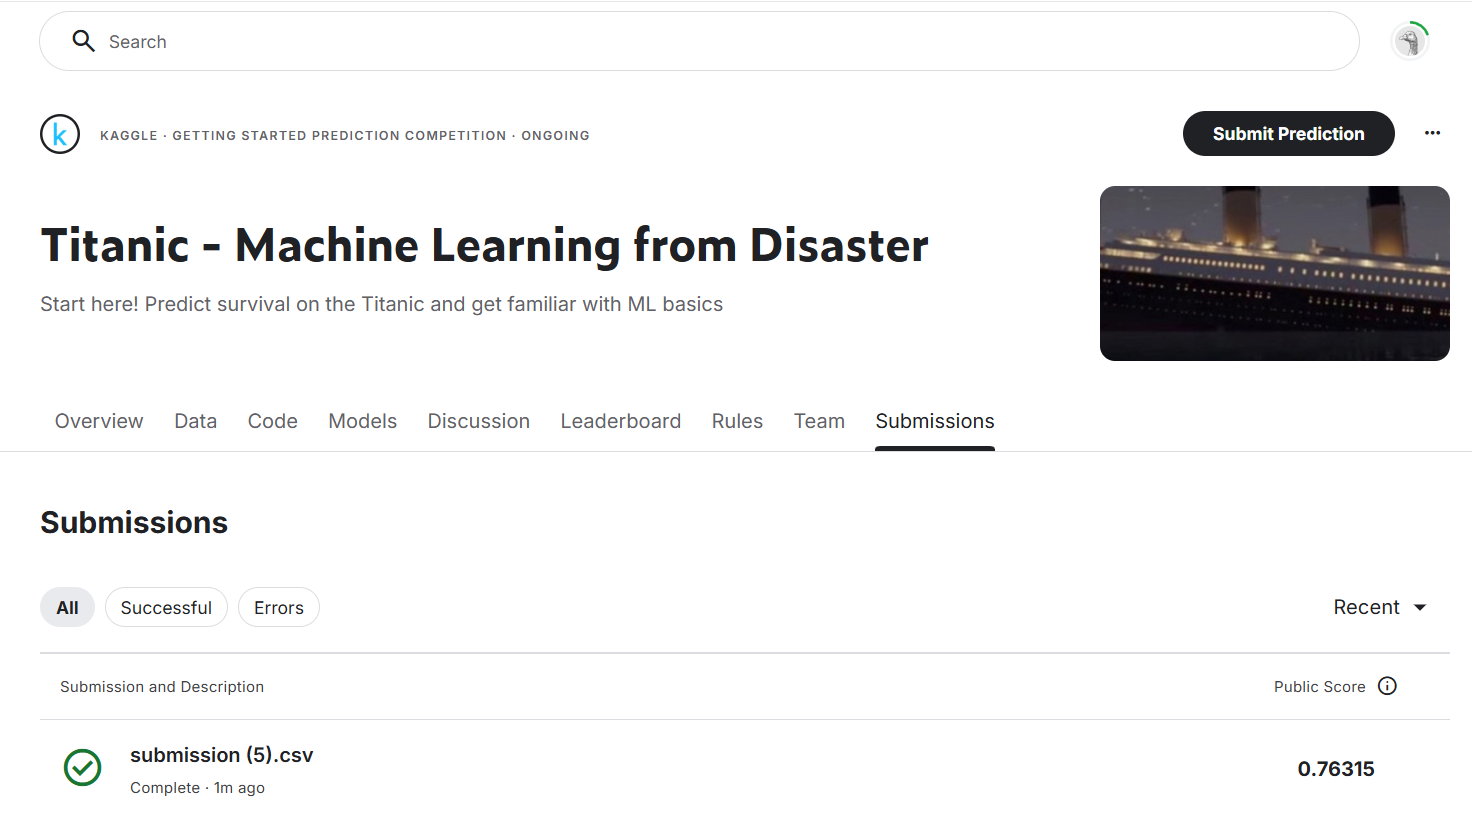

Качество на тесте хорошее , но всегда можно лучше , думаю , что необходимо больше внимания уделить тому что у некоторых пассажиров указано несколько мест в кабинке

3. Интерпретация

In [307]:
cat_explainer = shap.TreeExplainer(
    model, feature_perturbation="tree_path_dependent"
)
cat_shap_values = cat_explainer.shap_values(test_df)

<ipython-input-312-be990d52d239>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(cat_shap_values,test_df )


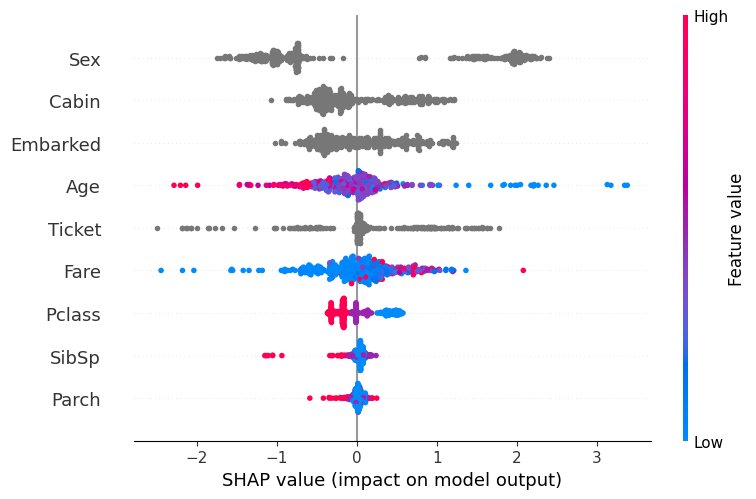

In [312]:

shap.summary_plot(cat_shap_values,test_df )

Итоги:
1.   Пол - оказал решающее влияние , что довольно логично с учетом того , что женщин спают первыми и у них более высокий болевой порог все дела
2.   Номер кабины - не меньшее влияние ,что говорит о том , что лучшего скора на тесте можно достичь подойдя более тщательно к обработке этой фичи
3.   Место посадки - влияет сильно , возможно титаник даже не доехал до одного из пунктов посадки и поэтмоу пассажиры с этих пунктов выжили
2.   Возраст - очевидно ,что чем старше человек тем ниже его шансы на выживание


